In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

class ForecastDataset(Dataset):
    def __init__(
            self,
            df: pd.DataFrame,
            seq_len: int,
            target: str,
            save_collumns: bool = False,
            exoq_collumns: list[str] = [],
            forecast_horizon: int = 1
        ):

        self.seq_len = seq_len
        self.forecast_horizon = forecast_horizon
        self.target = target
        self.exoq_collumns = exoq_collumns
        df = df.copy()
        source_cols = df.columns
        df_cols = [target] + exoq_collumns + [col for col in df.columns if col != target and save_collumns and col not in exoq_collumns] 
        # Преобразование даты в datetime если еще не преобразована
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)

        self.dates = df.index.copy()
        self.min_date = df.index.min()
        self.freq = self._infer_frequency(df.index)

        df = self._add_time_features(df)

        self.df = df
        self.exoq = df[exoq_collumns].values

        self.df_cols = df_cols
        self.feature_cols = [col for col in df.columns if col not in source_cols]

        self.values = df[df_cols + self.feature_cols].values


    def _infer_frequency(self, date_index):
        """Определяет частоту временного ряда"""

        return date_index[1] - date_index[0]

    def _add_time_features(self, df):
        """Добавляет временные признаки к DataFrame"""
        
        df['date'] = df.index

        
        df['dow_sin'] = np.sin(2 * np.pi * df['date'].dt.weekday / 7)
        df['dow_cos'] = np.cos(2 * np.pi * df['date'].dt.weekday / 7)
        df['month_sin'] = np.sin(2 * np.pi * (df['date'].dt.month-1) / 12)
        df['month_cos'] = np.cos(2 * np.pi * (df['date'].dt.month-1) / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.day / 31)
        df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.day / 31)
        df['is_holiday'] = (df['date'].dt.weekday > 4).astype(int)

        if not self.freq.days:
            df['hour_sin'] = np.sin(2 * np.pi * df['date'].dt.hour / 24)
            df['hour_cos'] = np.cos(2 * np.pi * df['date'].dt.hour / 24)
        
        df = df.drop('date', axis=1)

        return df

    def get_future_time_features(self, start_date, horizon):
        """
        Генерирует временные признаки для будущих дат
        """
        future_dates = pd.date_range(start=start_date, periods=horizon+1, freq=self.freq)[1:]
        future_df = pd.DataFrame(index=future_dates)
        future_df['date'] = future_df.index

        # Добавляем временные признаки
        future_df = self._add_time_features(future_df)

        # Получаем только временные признаки (без целевой переменной)
        time_features = future_df[self.feature_cols].values

        return torch.tensor(time_features, dtype=torch.float32)

    def set_forecast_horizon(
        self,
        horizon
    ):
        self.forecast_horizon = horizon

    def __len__(self):
        return len(self.df) - self.seq_len - self.forecast_horizon + 1
    
    def get_exoq(self, idx):
        exoq = self.exoq[idx + self.seq_len:idx + self.seq_len + self.forecast_horizon]
        return torch.tensor(exoq, dtype=torch.float32)


    def __getitem__(self, idx):
        # Входная последовательность для энкодера
        x_encoder = self.values[idx:idx + self.seq_len]

        # Целевая последовательность фактических значений
        y_true = self.values[idx + self.seq_len:idx + self.seq_len + self.forecast_horizon, 0]

        # Получаем временные признаки для горизонта прогнозирования
        start_date = self.dates[idx + self.seq_len - 1]
        future_time_features = self.get_future_time_features(start_date, self.forecast_horizon)
        exoq = self.get_exoq(idx)
   
        return {
            'encoder_input': torch.tensor(x_encoder, dtype=torch.float32),
            'decoder_targets': torch.tensor(y_true, dtype=torch.float32),
            'future_time_features': torch.cat([exoq, future_time_features],dim=1)
        }


In [2]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


def prepare_data(
    df,
    target_col,
    seq_len,
    train_horizon=7,
    val_horizon=7,
    save_collumns = False,
    batch_size=32,
    val_ratio=0.2,
    exoq = []
):

    train_df, test_df = train_test_split(df, test_size=val_ratio, shuffle=False)
    # Создаем датасет
    train_dataset = ForecastDataset(train_df, seq_len, target_col, save_collumns,exoq, train_horizon)
    val_dataset = ForecastDataset(test_df, seq_len, target_col, save_collumns,exoq, val_horizon)

    # Создаем DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    input_size = next(iter(train_loader))["encoder_input"].size(2)
    features_size = next(iter(train_loader))["future_time_features"].size(2)

    return train_loader, val_loader, input_size, features_size



In [3]:
from scipy.stats import zscore

def ts_from_csv(csv_path, resampling = "h"):
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'])
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
    df['date_time'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

    df.set_index('date_time', inplace=True)
    df.drop(columns=['date', 'time'], inplace=True)

    df = df.resample(resampling).sum().fillna(0)
    for col in df.columns:
        df[col] = np.where(zscore(df[col]) > 3, df[col].mean(), df[col])

    return df

def load_data(
    csv_path,
    freq
):
    if isinstance(csv_path, str):
        df = ts_from_csv(csv_path, freq)
    elif isinstance(csv_path , list):
        dfs = [
            ts_from_csv(csv, freq) for csv in csv_path
        ]
        df = pd.concat(
            dfs,
            axis=1,
            join = 'inner'
        )
    for col in df.columns:
        df[col]/=df[col].max()

    return df

In [4]:
import torch.nn as nn

class BaseForecast(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, rnn ,num_layers: int = 2):
        super().__init__()
        self.lstm = rnn(input_size, hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(
            self,
            inp,
            future = [],
            src = None,
            teacher_forcing_ratio = 0.5
        ):
        # inp: [batch, seq_len, input_size]
        preds = []
        out, (hidden) = self.lstm(inp)
        out = out[:, -1, :]
        preds.append(self.fc(out))
        for i in range(len(future[-1])-1):
            if src is not None:
                teacher_force = torch.rand(1).item() < teacher_forcing_ratio
                last_target = src[:,i].unsqueeze(1) if teacher_force else preds[-1]
            else:
                last_target = preds[-1]

            cur_inp = torch.cat([last_target,future[:,i,:]], dim=1).unsqueeze(1)
            out, (hidden) = self.lstm(cur_inp, (hidden))
            out = out[:, -1, :]
            preds.append(self.fc(out))

        return torch.cat(preds, dim=1)

class LSTMForecast(BaseForecast):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 2):
        super().__init__(input_size, hidden_size, nn.LSTM, num_layers)

class GRUForecast(BaseForecast):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int = 2):
        super().__init__(input_size, hidden_size, nn.GRU, num_layers)


In [5]:
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error
)

def train_model(model, train_loader, val_loader, epochs=30, learning_rate=0.001, teacher_forcing_ratio=0.5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    torch.random.manual_seed(42)
    criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
    best_val_loss = float('inf')


    for epoch in range(epochs):
        # Обучение
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            encoder_input = batch['encoder_input'].to(device)
            decoder_targets = batch['decoder_targets'].to(device)
            future_time_features = batch['future_time_features'].to(device)

            optimizer.zero_grad()
            output = model(encoder_input, future_time_features, decoder_targets, teacher_forcing_ratio)
            loss = criterion(output.squeeze(), decoder_targets)
            loss.backward()
           
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_loader)
        scheduler.step()

        # Валидация
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                encoder_input = batch['encoder_input'].to(device)
                decoder_targets = batch['decoder_targets'].to(device)
                future_time_features = batch['future_time_features'].to(device)

                output = model(encoder_input, future_time_features)  
                loss = criterion(output.squeeze(), decoder_targets)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        # Сохранение лучшей модели
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_hybrid_model.pth')

        # Логирование и сохранение лучшей модели
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    model.load_state_dict(torch.load('best_hybrid_model.pth'))
    preds = []
    targets = []
    with torch.no_grad():
        for batch in val_loader:
            inp = batch["encoder_input"].to(device)
            target = batch["decoder_targets"].to(device)
            future = batch['future_time_features'].to(device)
            p = model(inp,future,).squeeze(-1).cpu().numpy()
            preds.extend(p)
            targets.extend(target.cpu().numpy())


    rmse = np.sqrt(mean_squared_error(targets, preds, multioutput="raw_values"))
    mae  = mean_absolute_error(targets, preds, multioutput="raw_values")
    
    # Визуализация
    plt.figure(figsize=(10, 5))
    plt.plot(targets[-1], label="Target")
    plt.plot(preds[-1], label="Predictions")

    # plt.xticks(ticks=np.arange(len(rmse)), labels=[str(i) for i in range(1, len(rmse)+1)])
    plt.title('forecast')
    plt.xlabel('Horizon')
    plt.ylabel('Value')
    plt.show()
    if False:
        plt.figure(figsize=(10, 5))
        plt.plot(rmse,)
        # plt.xticks(ticks=np.arange(len(rmse)), labels=[str(i) for i in range(1, len(rmse)+1)])
        plt.title('RMSE')
        plt.xlabel('Horizon')
        plt.ylabel('Value')
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(mae,)
        # plt.xticks(ticks=np.arange(len(mae)), labels=[str(i) for i in range(1, len(mae)+1)])
        plt.title('MAE')
        plt.xlabel('Horizon')
        plt.ylabel('Value')
        plt.show()

    return  mae, rmse

## SEQ2SEQ

In [6]:
import torch
import torch.nn as nn

class Seq2SeqForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, time_feature_size, ):
        super(Seq2SeqForecast, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Энкодер
        self.encoder = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
    
        )

        self.dec0 = nn.Linear(hidden_size, hidden_size)

        # Декодер принимает предсказанное значение объема + временные признаки
        self.decoder = nn.GRUCell(
            input_size=1 + time_feature_size, 
            hidden_size=hidden_size,
        )

        # Полносвязный слой для финального преобразования
        self.fc = nn.Linear(hidden_size, 1)


    def forward(self, src, future_time_features, targets=None, teacher_forcing_ratio=0.5):

        batch_size = src.size(0)
        horizon = future_time_features.size(1)

        states, _ = self.encoder(src)

        outputs = torch.zeros(batch_size, horizon, 1, device=src.device)

        last_value = src[:, -1, 0].unsqueeze(1)  # [batch_size, 1]
        hidden = states[:,-1,:]
        hidden = self.dec0(hidden)


        # Декодирование
        for t in range(horizon):
            current_time_features = future_time_features[:, t, :]  # [batch_size, time_feature_size]

            decoder_input = torch.cat([last_value, current_time_features], dim=1)

            # Передаем через декодер
            hidden = self.decoder(decoder_input, hidden)
           
            prediction = self.fc(hidden)  # [batch_size, 1]
            outputs[:, t] = prediction

            if targets is not None and t < horizon-1:
                teacher_force = torch.rand(1).item() < teacher_forcing_ratio
                last_value = targets[:, t].unsqueeze(1) if teacher_force else prediction
            else:
                last_value = prediction

        return outputs


In [7]:
import torch
import torch.nn as nn

class AttentionSeq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, time_feature_size,  ):
        super(AttentionSeq2Seq, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Энкодер 
        self.encoder = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        self.dec0 = nn.Linear(hidden_size, hidden_size)

        # Декодер принимает предсказанное значение объема + временные признаки
        self.decoder = nn.GRUCell(
            input_size=1 + time_feature_size + hidden_size,  
            hidden_size=hidden_size ,
        )

        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=1, batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, src, future_time_features, targets=None, teacher_forcing_ratio=0.5):

        batch_size = src.size(0)
        horizon = future_time_features.size(1)

        states, _ = self.encoder(src)

        outputs = torch.zeros(batch_size, horizon, 1, device=src.device)

        last_value = src[:, -1, 0].unsqueeze(1)  # [batch_size, 1]
        hidden = states[:,-1,:]
        hidden = self.dec0(hidden)


        # Декодирование
        for t in range(horizon):
            current_time_features = future_time_features[:, t, :]  # [batch_size, time_feature_size]

            attention, _ = self.attention(hidden.unsqueeze(1), states, states)
       
            decoder_input = torch.cat([last_value, current_time_features, attention.squeeze(1)], dim=1)
            hidden = self.decoder(decoder_input, hidden)
        
            prediction = self.fc(hidden)  # [batch_size, 1]
            outputs[:, t] = prediction

            if targets is not None and t < horizon-1:
                teacher_force = torch.rand(1).item() < teacher_forcing_ratio
                last_value = targets[:, t].unsqueeze(1) if teacher_force else prediction
            else:
                last_value = prediction

        return outputs


In [8]:
def plot_metrics(
    mae_results,
    rmse_results 
):
    plt.figure(figsize=(10, 5))
    for model, mae in mae_results.items():
        plt.plot(mae, label=model)
    plt.legend()
    plt.title('MAE')
    plt.xlabel('Horizon')
    plt.ylabel('Value')
    plt.show()

    plt.figure(figsize=(10, 5))
    for model, rmse in rmse_results.items():
        plt.plot(rmse, label=model)
    plt.legend()
    plt.title('RMSE')
    plt.xlabel('Horizon')
    plt.ylabel('Value')
    plt.show()  

In [9]:
import os
import json
def save_results(
    dir,
    mae_results,
    rmse_results 
):
    with open(os.path.join(dir,"eval_metrics.json"), "w") as f:
        json.dump(
            {"MAE": mae_results, "RMSE": rmse_results},
            f
        )

### incoming day

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [11]:
mae_results = {}
rmse_results = {}

In [12]:
# Гиперпараметры
SEQ_LEN = 14  # длина входной последовательность
TRAIN_HORIZON = 7  # длина прогноза для обучения
EVAL_HORIZON = 30  # длина прогноза для валидации

BATCH_SIZE = 32
HIDDEN_SIZE = 128
NUM_LAYER = 1
EPOCHS = 10
LR = 1e-3
data = "incoming.csv"
target ="incoming_volume" 
save_dir = "torch_sarima/inc_day"
freq = "D"


In [13]:
df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
train, test = train_test_split(df, test_size=0.2, shuffle=False)
model = SARIMAX(
    train[target],
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit(disp=False)


Epoch 1/10, Train Loss: 0.0153, Val Loss: 0.0276
Epoch 2/10, Train Loss: 0.0151, Val Loss: 0.0248
Epoch 3/10, Train Loss: 0.0149, Val Loss: 0.0273
Epoch 4/10, Train Loss: 0.0148, Val Loss: 0.0247
Epoch 5/10, Train Loss: 0.0147, Val Loss: 0.0250
Epoch 6/10, Train Loss: 0.0147, Val Loss: 0.0256
Epoch 7/10, Train Loss: 0.0147, Val Loss: 0.0255
Epoch 8/10, Train Loss: 0.0146, Val Loss: 0.0254
Epoch 9/10, Train Loss: 0.0146, Val Loss: 0.0253
Epoch 10/10, Train Loss: 0.0146, Val Loss: 0.0253


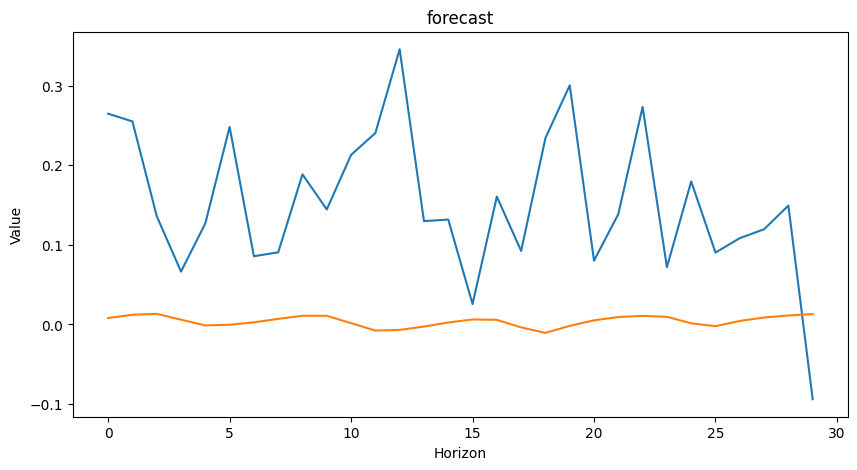

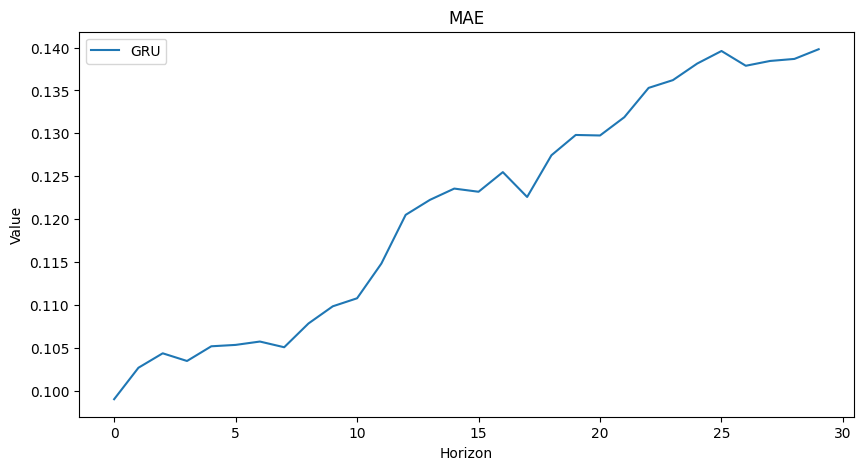

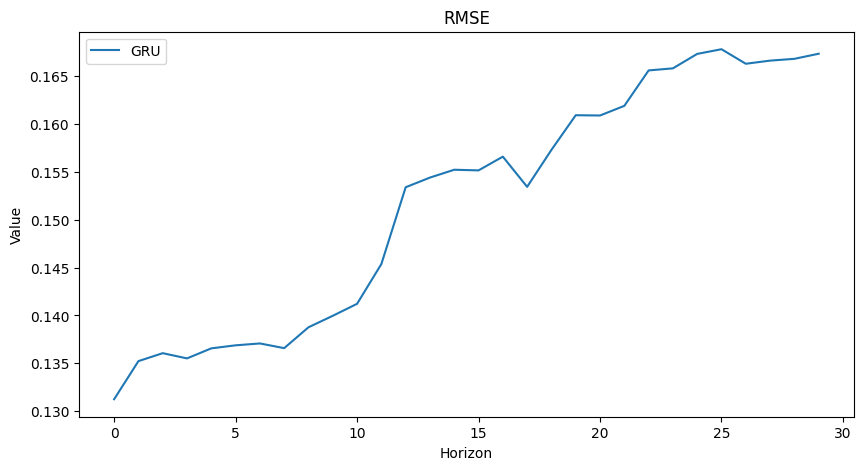

In [14]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = LSTMForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)
model_name = "GRU"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

plot_metrics(mae_results, rmse_results)

# torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')

Epoch 1/10, Train Loss: 0.0160, Val Loss: 0.0321
Epoch 2/10, Train Loss: 0.0153, Val Loss: 0.0243
Epoch 3/10, Train Loss: 0.0150, Val Loss: 0.0265
Epoch 4/10, Train Loss: 0.0149, Val Loss: 0.0262
Epoch 5/10, Train Loss: 0.0148, Val Loss: 0.0256
Epoch 6/10, Train Loss: 0.0148, Val Loss: 0.0259
Epoch 7/10, Train Loss: 0.0148, Val Loss: 0.0260
Epoch 8/10, Train Loss: 0.0148, Val Loss: 0.0259
Epoch 9/10, Train Loss: 0.0148, Val Loss: 0.0259
Epoch 10/10, Train Loss: 0.0148, Val Loss: 0.0259


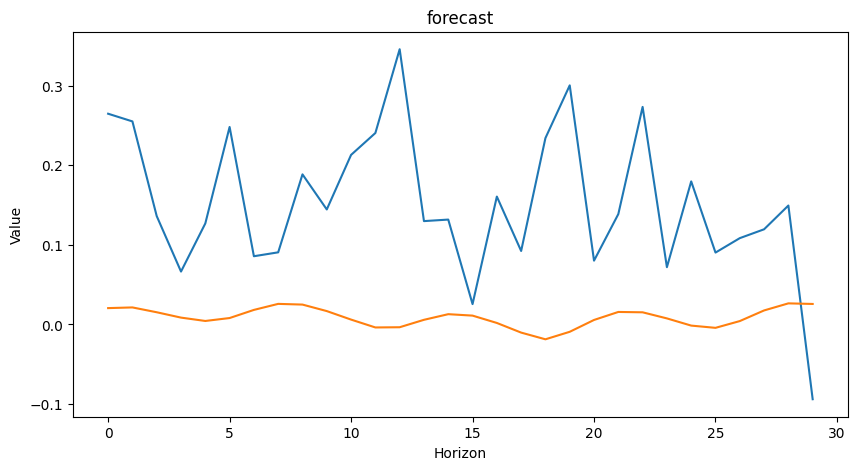

In [15]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = LSTMForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "LSTM"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')


Epoch 1/10, Train Loss: 0.0164, Val Loss: 0.0252
Epoch 2/10, Train Loss: 0.0153, Val Loss: 0.0271
Epoch 3/10, Train Loss: 0.0150, Val Loss: 0.0267
Epoch 4/10, Train Loss: 0.0149, Val Loss: 0.0258
Epoch 5/10, Train Loss: 0.0148, Val Loss: 0.0265
Epoch 6/10, Train Loss: 0.0148, Val Loss: 0.0264
Epoch 7/10, Train Loss: 0.0148, Val Loss: 0.0263
Epoch 8/10, Train Loss: 0.0148, Val Loss: 0.0265
Epoch 9/10, Train Loss: 0.0148, Val Loss: 0.0264
Epoch 10/10, Train Loss: 0.0148, Val Loss: 0.0264


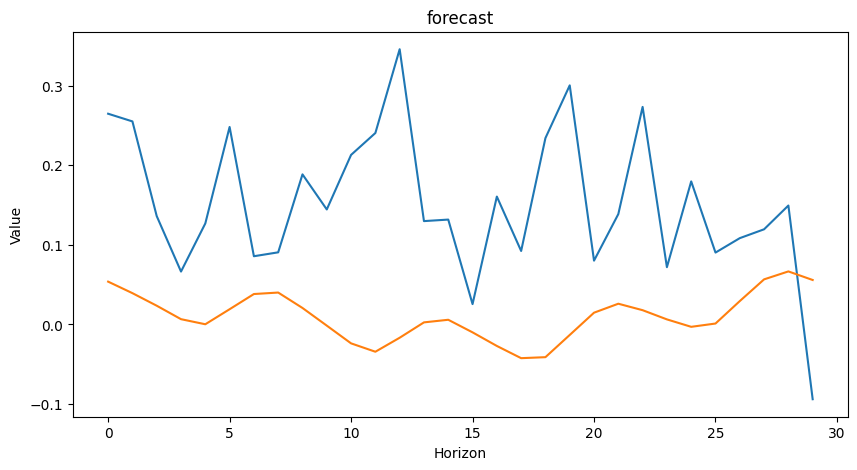

In [16]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0159, Val Loss: 0.0342
Epoch 2/10, Train Loss: 0.0154, Val Loss: 0.0242
Epoch 3/10, Train Loss: 0.0151, Val Loss: 0.0269
Epoch 4/10, Train Loss: 0.0149, Val Loss: 0.0247
Epoch 5/10, Train Loss: 0.0148, Val Loss: 0.0263
Epoch 6/10, Train Loss: 0.0148, Val Loss: 0.0260
Epoch 7/10, Train Loss: 0.0148, Val Loss: 0.0257
Epoch 8/10, Train Loss: 0.0148, Val Loss: 0.0258
Epoch 9/10, Train Loss: 0.0148, Val Loss: 0.0258
Epoch 10/10, Train Loss: 0.0148, Val Loss: 0.0259


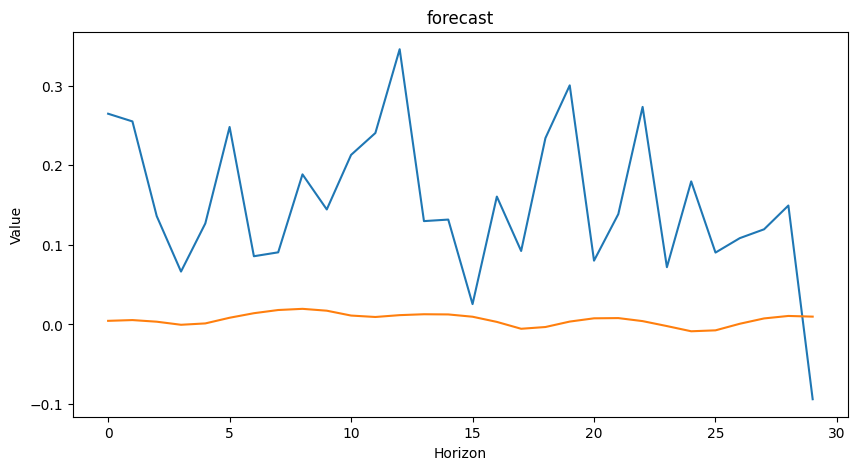

In [17]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)


mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0172, Val Loss: 0.0298
Epoch 2/10, Train Loss: 0.0154, Val Loss: 0.0248
Epoch 3/10, Train Loss: 0.0151, Val Loss: 0.0278
Epoch 4/10, Train Loss: 0.0150, Val Loss: 0.0246
Epoch 5/10, Train Loss: 0.0149, Val Loss: 0.0256
Epoch 6/10, Train Loss: 0.0149, Val Loss: 0.0260
Epoch 7/10, Train Loss: 0.0148, Val Loss: 0.0259
Epoch 8/10, Train Loss: 0.0148, Val Loss: 0.0258
Epoch 9/10, Train Loss: 0.0148, Val Loss: 0.0256
Epoch 10/10, Train Loss: 0.0148, Val Loss: 0.0257


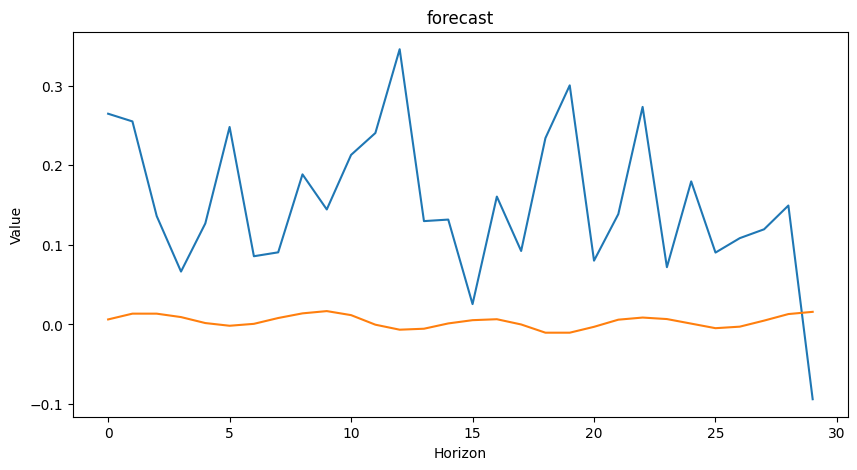

In [18]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)


model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_attention"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0165, Val Loss: 0.0337
Epoch 2/10, Train Loss: 0.0152, Val Loss: 0.0226
Epoch 3/10, Train Loss: 0.0151, Val Loss: 0.0276
Epoch 4/10, Train Loss: 0.0149, Val Loss: 0.0248
Epoch 5/10, Train Loss: 0.0148, Val Loss: 0.0256
Epoch 6/10, Train Loss: 0.0148, Val Loss: 0.0261
Epoch 7/10, Train Loss: 0.0147, Val Loss: 0.0257
Epoch 8/10, Train Loss: 0.0147, Val Loss: 0.0256
Epoch 9/10, Train Loss: 0.0147, Val Loss: 0.0256
Epoch 10/10, Train Loss: 0.0147, Val Loss: 0.0257


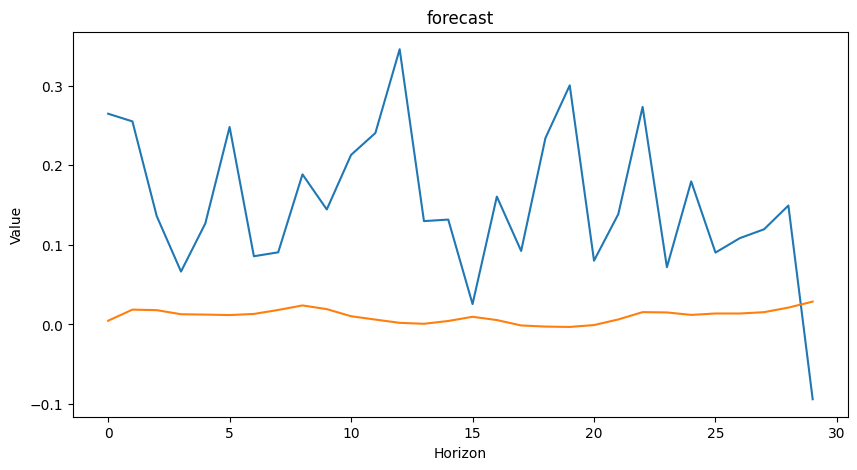

In [19]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)



model_name = "SEQ2SEQ_attention_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



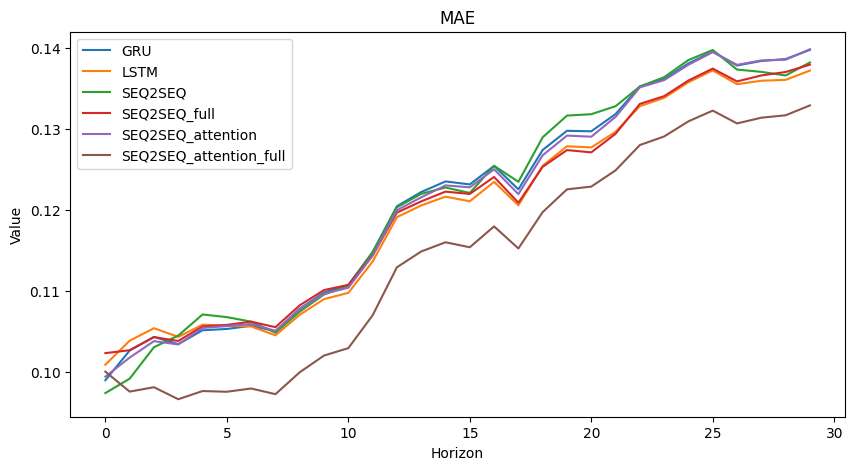

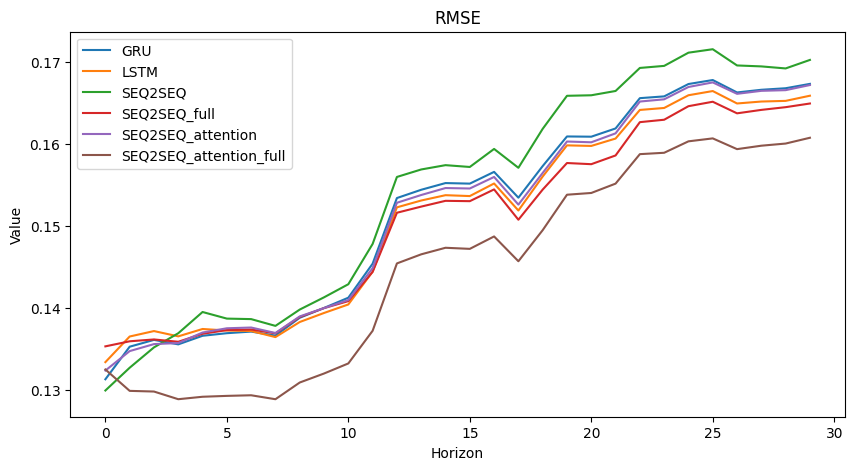

In [20]:
plot_metrics(mae_results, rmse_results)
save_results(save_dir, mae_results, rmse_results)

### Outgoing day

In [21]:
mae_results = {}
rmse_results = {}

In [22]:
# Гиперпараметры
SEQ_LEN = 14  # длина входной последовательность
TRAIN_HORIZON = 7  # длина прогноза для обучения
EVAL_HORIZON = 30  # длина прогноза для валидации

BATCH_SIZE = 32
HIDDEN_SIZE = 128
NUM_LAYER = 1
EPOCHS = 10
LR = 1e-3
data = "outcoming.csv"
target ="outgoing_volume" 
save_dir = "torch_sarima/out_day"
freq = "D"

In [23]:
df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
train, test = train_test_split(df, test_size=0.2, shuffle=False)
model = SARIMAX(
    train[target],
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit(disp=False)


Epoch 1/10, Train Loss: 0.0121, Val Loss: 0.0077
Epoch 2/10, Train Loss: 0.0116, Val Loss: 0.0085
Epoch 3/10, Train Loss: 0.0114, Val Loss: 0.0079
Epoch 4/10, Train Loss: 0.0113, Val Loss: 0.0082
Epoch 5/10, Train Loss: 0.0113, Val Loss: 0.0081
Epoch 6/10, Train Loss: 0.0112, Val Loss: 0.0082
Epoch 7/10, Train Loss: 0.0112, Val Loss: 0.0083
Epoch 8/10, Train Loss: 0.0112, Val Loss: 0.0083
Epoch 9/10, Train Loss: 0.0111, Val Loss: 0.0082
Epoch 10/10, Train Loss: 0.0111, Val Loss: 0.0082


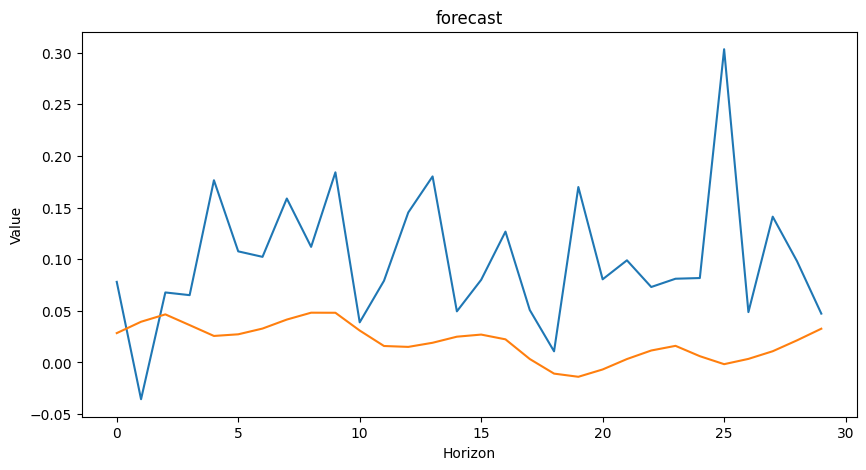

In [24]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = GRUForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)
model_name = "GRU"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')

Epoch 1/10, Train Loss: 0.0124, Val Loss: 0.0085
Epoch 2/10, Train Loss: 0.0117, Val Loss: 0.0077
Epoch 3/10, Train Loss: 0.0115, Val Loss: 0.0080
Epoch 4/10, Train Loss: 0.0114, Val Loss: 0.0077
Epoch 5/10, Train Loss: 0.0113, Val Loss: 0.0077
Epoch 6/10, Train Loss: 0.0113, Val Loss: 0.0077
Epoch 7/10, Train Loss: 0.0113, Val Loss: 0.0078
Epoch 8/10, Train Loss: 0.0112, Val Loss: 0.0079
Epoch 9/10, Train Loss: 0.0112, Val Loss: 0.0078
Epoch 10/10, Train Loss: 0.0112, Val Loss: 0.0078


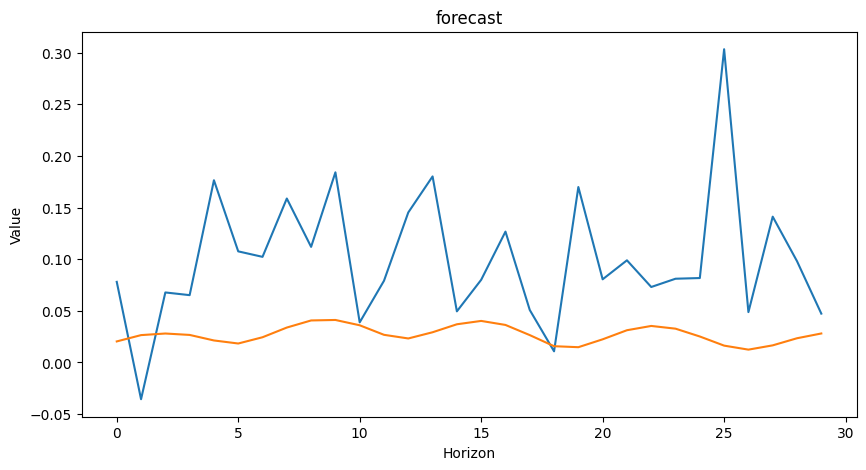

In [25]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = LSTMForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "LSTM"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')


Epoch 1/10, Train Loss: 0.0129, Val Loss: 0.0079
Epoch 2/10, Train Loss: 0.0118, Val Loss: 0.0084
Epoch 3/10, Train Loss: 0.0116, Val Loss: 0.0079
Epoch 4/10, Train Loss: 0.0114, Val Loss: 0.0081
Epoch 5/10, Train Loss: 0.0114, Val Loss: 0.0080
Epoch 6/10, Train Loss: 0.0113, Val Loss: 0.0079
Epoch 7/10, Train Loss: 0.0113, Val Loss: 0.0080
Epoch 8/10, Train Loss: 0.0113, Val Loss: 0.0081
Epoch 9/10, Train Loss: 0.0113, Val Loss: 0.0080
Epoch 10/10, Train Loss: 0.0113, Val Loss: 0.0080


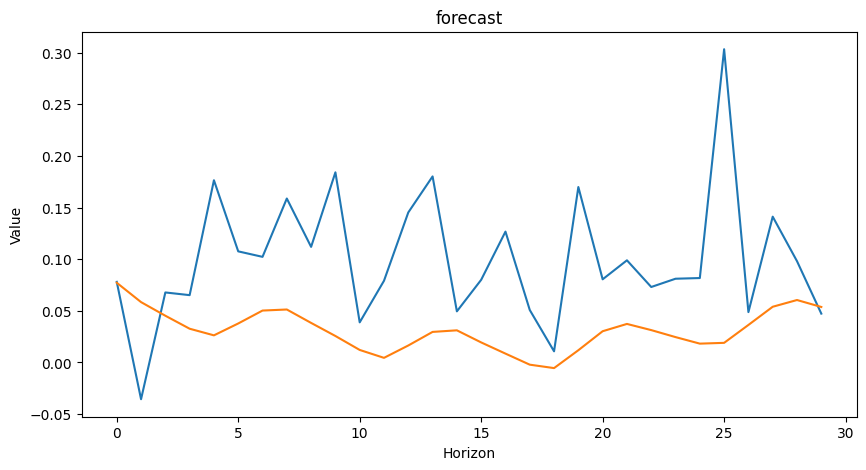

In [26]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0120, Val Loss: 0.0098
Epoch 2/10, Train Loss: 0.0117, Val Loss: 0.0080
Epoch 3/10, Train Loss: 0.0114, Val Loss: 0.0077
Epoch 4/10, Train Loss: 0.0114, Val Loss: 0.0081
Epoch 5/10, Train Loss: 0.0113, Val Loss: 0.0078
Epoch 6/10, Train Loss: 0.0113, Val Loss: 0.0078
Epoch 7/10, Train Loss: 0.0112, Val Loss: 0.0079
Epoch 8/10, Train Loss: 0.0112, Val Loss: 0.0080
Epoch 9/10, Train Loss: 0.0112, Val Loss: 0.0079
Epoch 10/10, Train Loss: 0.0112, Val Loss: 0.0078


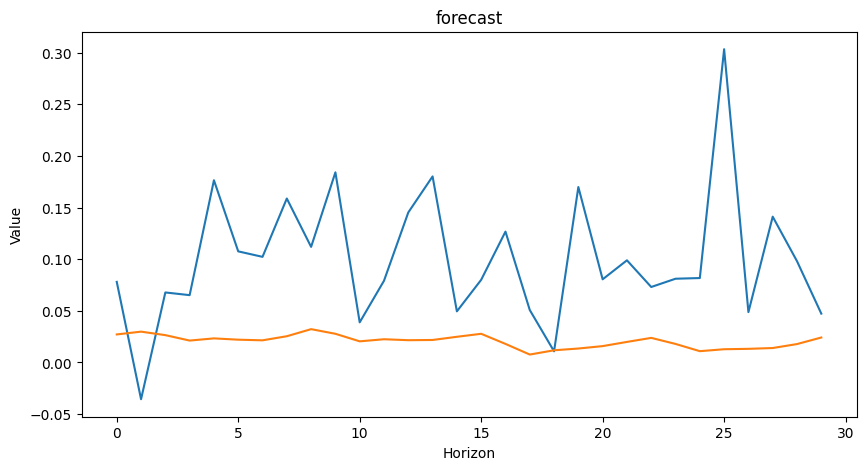

In [27]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)


mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0137, Val Loss: 0.0082
Epoch 2/10, Train Loss: 0.0119, Val Loss: 0.0083
Epoch 3/10, Train Loss: 0.0116, Val Loss: 0.0080
Epoch 4/10, Train Loss: 0.0115, Val Loss: 0.0080
Epoch 5/10, Train Loss: 0.0115, Val Loss: 0.0080
Epoch 6/10, Train Loss: 0.0114, Val Loss: 0.0080
Epoch 7/10, Train Loss: 0.0114, Val Loss: 0.0081
Epoch 8/10, Train Loss: 0.0114, Val Loss: 0.0082
Epoch 9/10, Train Loss: 0.0113, Val Loss: 0.0081
Epoch 10/10, Train Loss: 0.0113, Val Loss: 0.0080


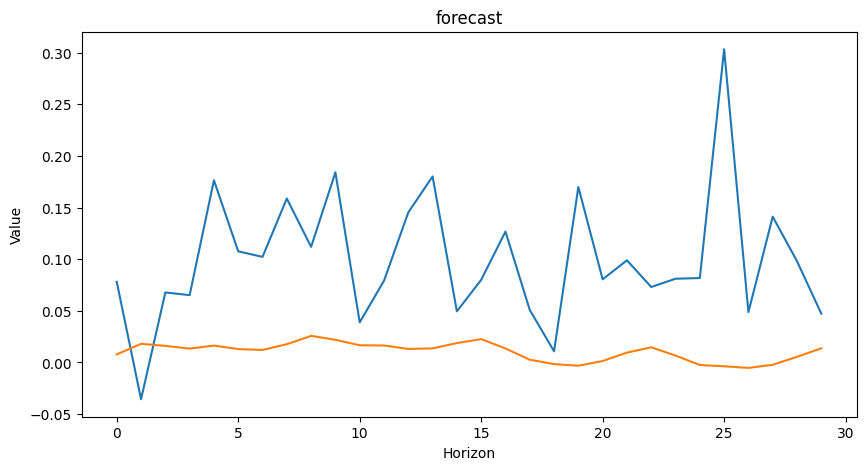

In [28]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)


model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_attention"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0130, Val Loss: 0.0107
Epoch 2/10, Train Loss: 0.0118, Val Loss: 0.0091
Epoch 3/10, Train Loss: 0.0116, Val Loss: 0.0090
Epoch 4/10, Train Loss: 0.0115, Val Loss: 0.0088
Epoch 5/10, Train Loss: 0.0114, Val Loss: 0.0088
Epoch 6/10, Train Loss: 0.0114, Val Loss: 0.0086
Epoch 7/10, Train Loss: 0.0114, Val Loss: 0.0087
Epoch 8/10, Train Loss: 0.0114, Val Loss: 0.0088
Epoch 9/10, Train Loss: 0.0113, Val Loss: 0.0087
Epoch 10/10, Train Loss: 0.0113, Val Loss: 0.0087


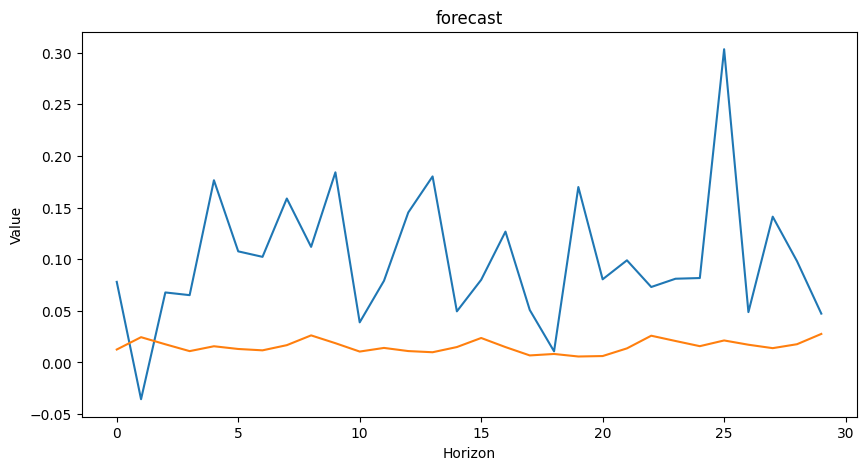

In [29]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=5e-4
)


model_name = "SEQ2SEQ_attention_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



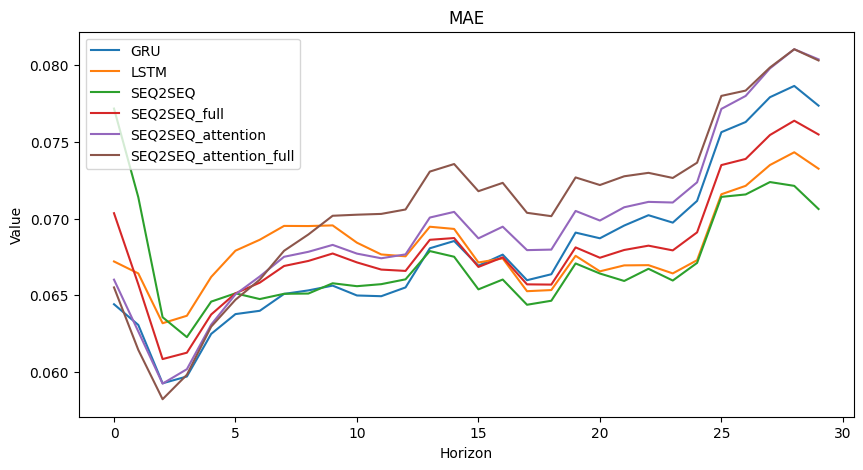

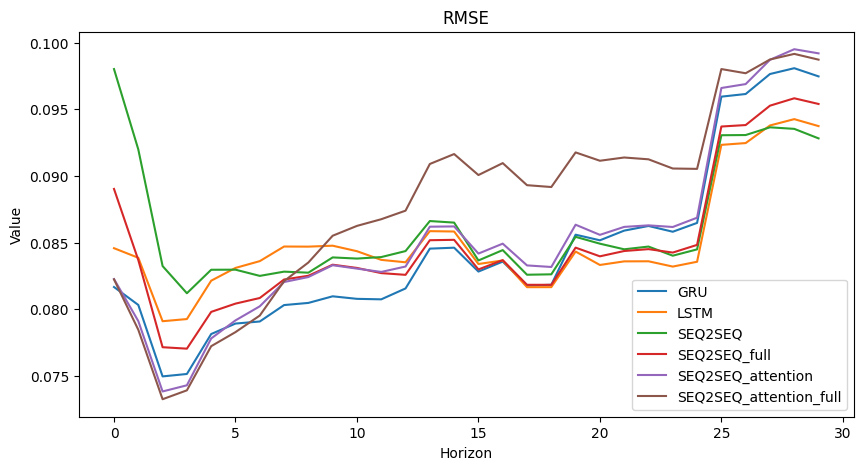

In [30]:
plot_metrics(mae_results, rmse_results)
save_results(save_dir, mae_results, rmse_results)

### Incoming hour

In [31]:
mae_results = {}
rmse_results = {}

In [32]:
# Гиперпараметры
SEQ_LEN = 24*2  # длина входной последовательность
TRAIN_HORIZON = 24*2  # длина прогноза для обучения
EVAL_HORIZON = 24*7  # длина прогноза для валидации

BATCH_SIZE = 32
HIDDEN_SIZE = 128
NUM_LAYER = 2
EPOCHS = 10
LR = 1e-3
data = "incoming.csv"
target ="incoming_volume" 
save_dir = "torch_sarima/inc_hour"

freq = "h"

In [33]:
df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
train, test = train_test_split(df, test_size=0.2, shuffle=False)
model = SARIMAX(
    train[target],
    order=(3, 0, 1),
    seasonal_order=(3, 0, 3, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit(disp=False)


/mnt/c/Users/aa/projects/Diplom_forecast/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Epoch 1/10, Train Loss: 0.0199, Val Loss: 0.0241
Epoch 2/10, Train Loss: 0.0195, Val Loss: 0.0239
Epoch 3/10, Train Loss: 0.0191, Val Loss: 0.0241
Epoch 4/10, Train Loss: 0.0187, Val Loss: 0.0239
Epoch 5/10, Train Loss: 0.0184, Val Loss: 0.0241
Epoch 6/10, Train Loss: 0.0180, Val Loss: 0.0244
Epoch 7/10, Train Loss: 0.0177, Val Loss: 0.0243
Epoch 8/10, Train Loss: 0.0174, Val Loss: 0.0246
Epoch 9/10, Train Loss: 0.0172, Val Loss: 0.0247
Epoch 10/10, Train Loss: 0.0170, Val Loss: 0.0248


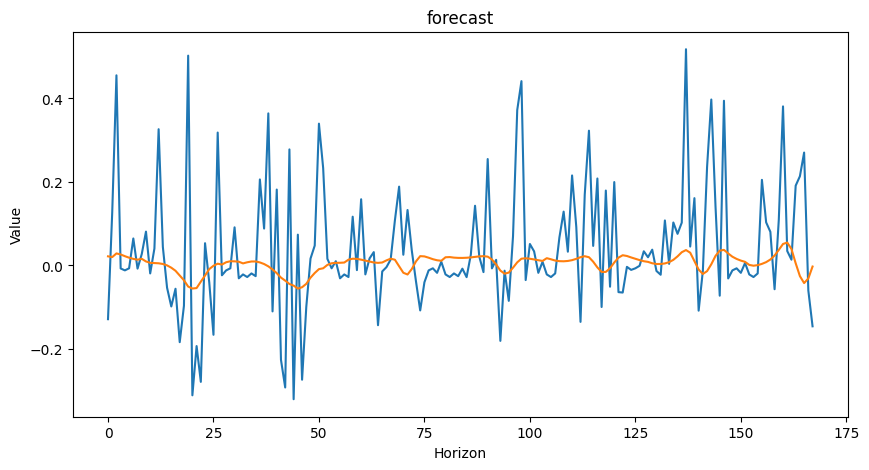

In [34]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = GRUForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)
model_name = "GRU"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')

Epoch 1/10, Train Loss: 0.0198, Val Loss: 0.0241
Epoch 2/10, Train Loss: 0.0192, Val Loss: 0.0241
Epoch 3/10, Train Loss: 0.0184, Val Loss: 0.0244
Epoch 4/10, Train Loss: 0.0172, Val Loss: 0.0262
Epoch 5/10, Train Loss: 0.0151, Val Loss: 0.0281
Epoch 6/10, Train Loss: 0.0130, Val Loss: 0.0294
Epoch 7/10, Train Loss: 0.0116, Val Loss: 0.0302
Epoch 8/10, Train Loss: 0.0105, Val Loss: 0.0306
Epoch 9/10, Train Loss: 0.0099, Val Loss: 0.0316
Epoch 10/10, Train Loss: 0.0093, Val Loss: 0.0321


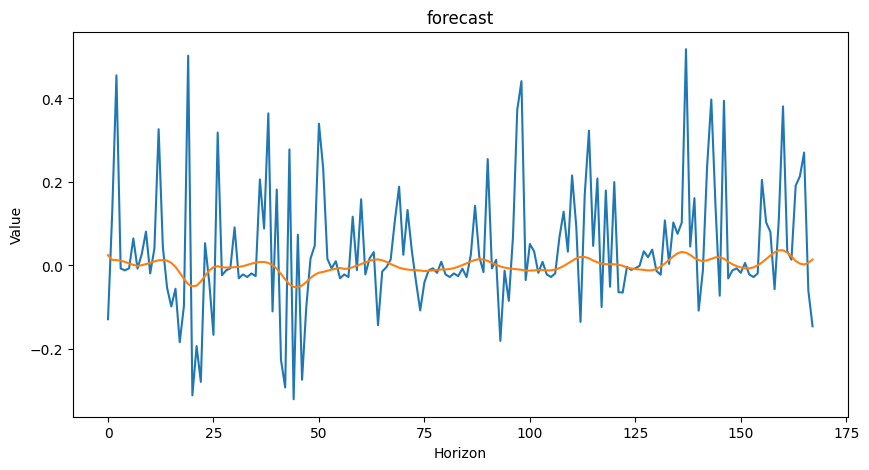

In [35]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = LSTMForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "LSTM"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')


Epoch 1/10, Train Loss: 0.0198, Val Loss: 0.0243
Epoch 2/10, Train Loss: 0.0194, Val Loss: 0.0238
Epoch 3/10, Train Loss: 0.0192, Val Loss: 0.0241
Epoch 4/10, Train Loss: 0.0190, Val Loss: 0.0232
Epoch 5/10, Train Loss: 0.0187, Val Loss: 0.0235
Epoch 6/10, Train Loss: 0.0185, Val Loss: 0.0235
Epoch 7/10, Train Loss: 0.0184, Val Loss: 0.0235
Epoch 8/10, Train Loss: 0.0182, Val Loss: 0.0235
Epoch 9/10, Train Loss: 0.0182, Val Loss: 0.0237
Epoch 10/10, Train Loss: 0.0181, Val Loss: 0.0236


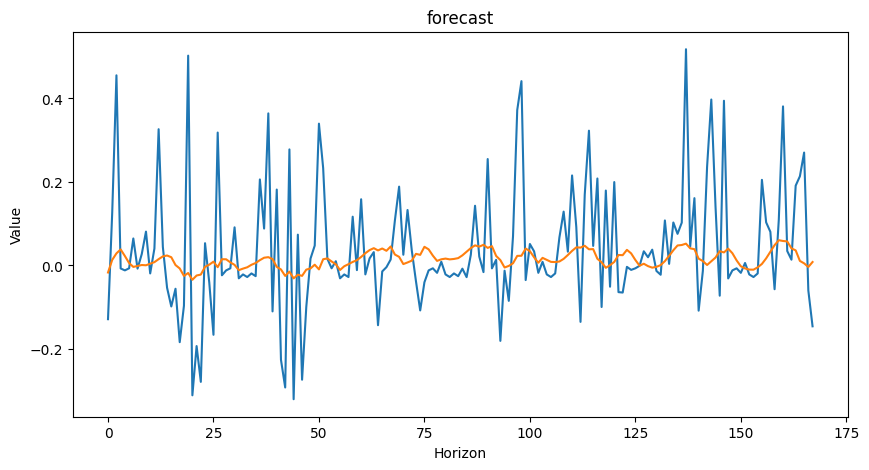

In [36]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0199, Val Loss: 0.0247
Epoch 2/10, Train Loss: 0.0194, Val Loss: 0.0236
Epoch 3/10, Train Loss: 0.0192, Val Loss: 0.0240
Epoch 4/10, Train Loss: 0.0189, Val Loss: 0.0235
Epoch 5/10, Train Loss: 0.0187, Val Loss: 0.0237
Epoch 6/10, Train Loss: 0.0184, Val Loss: 0.0235
Epoch 7/10, Train Loss: 0.0183, Val Loss: 0.0237
Epoch 8/10, Train Loss: 0.0181, Val Loss: 0.0235
Epoch 9/10, Train Loss: 0.0181, Val Loss: 0.0238
Epoch 10/10, Train Loss: 0.0181, Val Loss: 0.0236


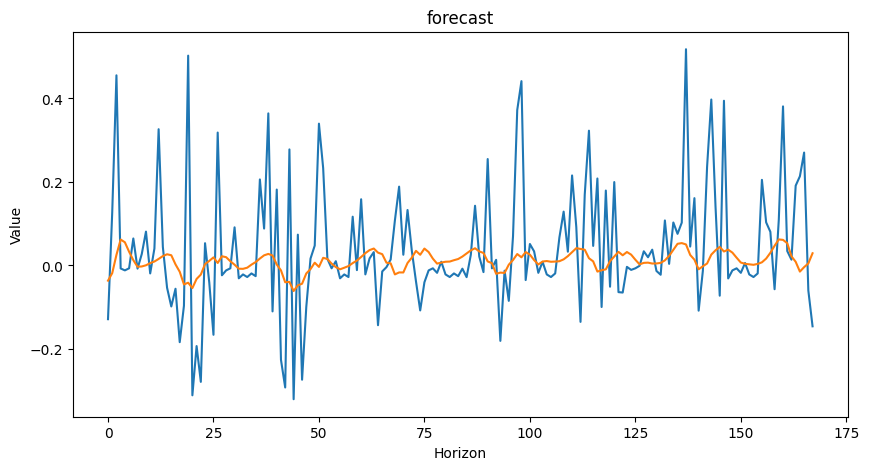

In [37]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)


mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0201, Val Loss: 0.0242
Epoch 2/10, Train Loss: 0.0194, Val Loss: 0.0237
Epoch 3/10, Train Loss: 0.0191, Val Loss: 0.0246
Epoch 4/10, Train Loss: 0.0189, Val Loss: 0.0236
Epoch 5/10, Train Loss: 0.0186, Val Loss: 0.0236
Epoch 6/10, Train Loss: 0.0184, Val Loss: 0.0239
Epoch 7/10, Train Loss: 0.0182, Val Loss: 0.0240
Epoch 8/10, Train Loss: 0.0179, Val Loss: 0.0240
Epoch 9/10, Train Loss: 0.0178, Val Loss: 0.0244
Epoch 10/10, Train Loss: 0.0176, Val Loss: 0.0243


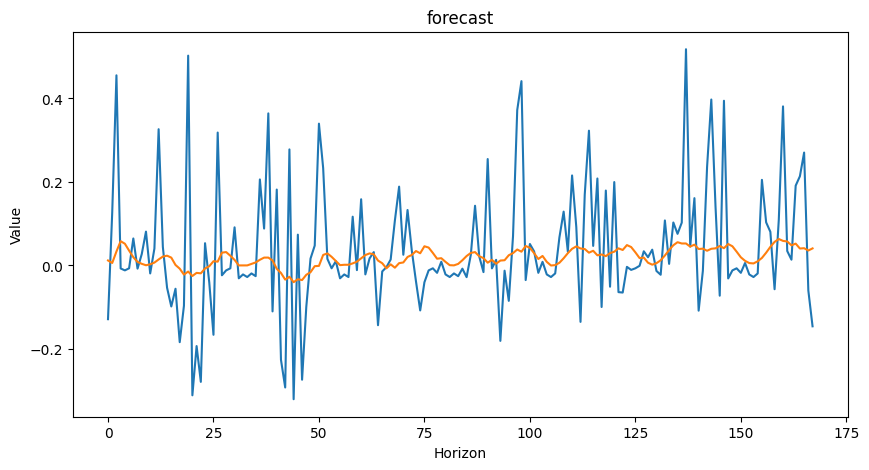

In [38]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)


model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_attention"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0198, Val Loss: 0.0238
Epoch 2/10, Train Loss: 0.0194, Val Loss: 0.0233
Epoch 3/10, Train Loss: 0.0190, Val Loss: 0.0246
Epoch 4/10, Train Loss: 0.0188, Val Loss: 0.0236
Epoch 5/10, Train Loss: 0.0184, Val Loss: 0.0235
Epoch 6/10, Train Loss: 0.0181, Val Loss: 0.0235
Epoch 7/10, Train Loss: 0.0178, Val Loss: 0.0237
Epoch 8/10, Train Loss: 0.0175, Val Loss: 0.0241
Epoch 9/10, Train Loss: 0.0174, Val Loss: 0.0240
Epoch 10/10, Train Loss: 0.0173, Val Loss: 0.0240


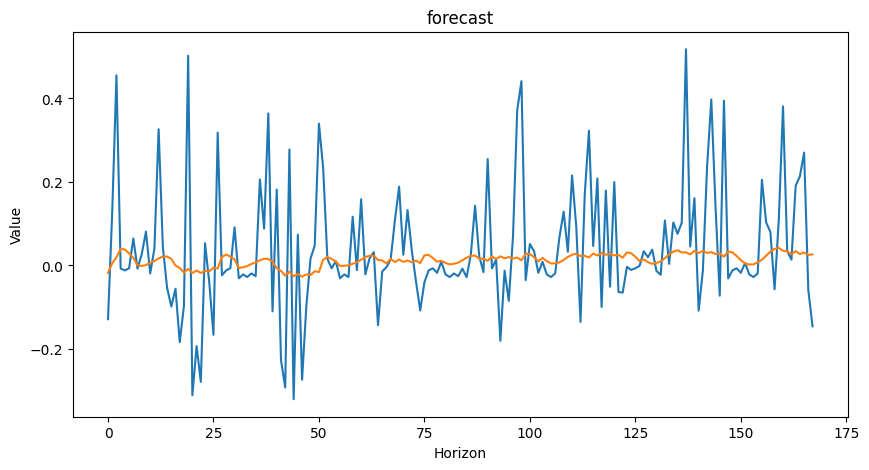

In [39]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_attention_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



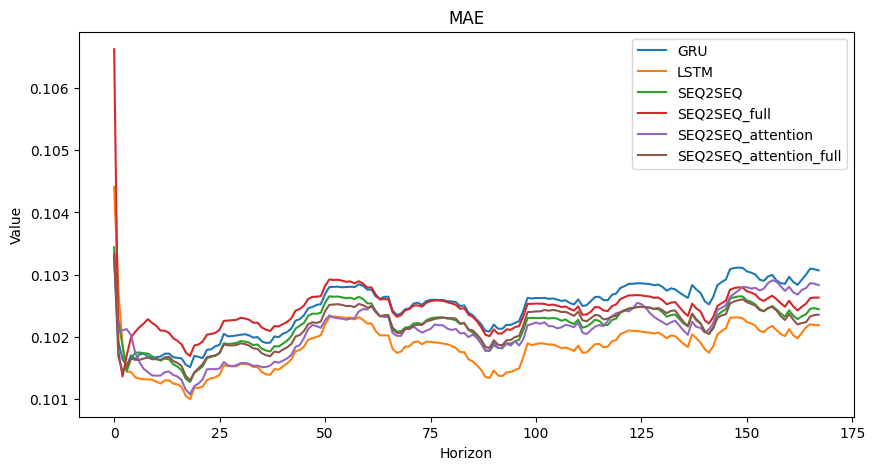

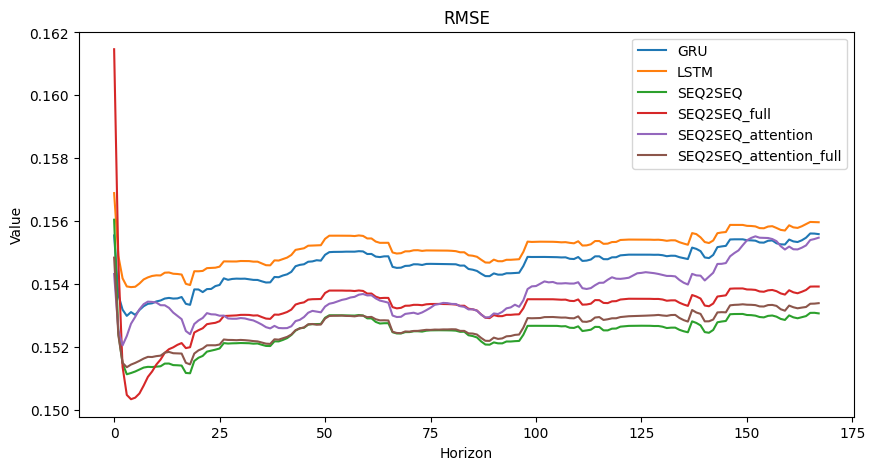

In [40]:
plot_metrics(mae_results, rmse_results)
save_results(save_dir, mae_results, rmse_results)

### Outgoing hour

In [41]:
mae_results = {}
rmse_results = {}

In [42]:
# Гиперпараметры
SEQ_LEN = 24*2  # длина входной последовательность
TRAIN_HORIZON = 24*2  # длина прогноза для обучения
EVAL_HORIZON = 24*7  # длина прогноза для валидации

BATCH_SIZE = 32
HIDDEN_SIZE = 128
NUM_LAYER = 2
EPOCHS = 10
LR = 1e-3
data = "outcoming.csv"
target ="outgoing_volume" 
save_dir = "torch_sarima/out_hour"

freq = "h"

In [43]:
df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
train, test = train_test_split(df, test_size=0.2, shuffle=False)
model = SARIMAX(
    train[target],
    order=(3, 0, 4),
    seasonal_order=(1, 0, 1, 24),   
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit(disp=False)


/mnt/c/Users/aa/projects/Diplom_forecast/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Epoch 1/10, Train Loss: 0.0264, Val Loss: 0.0291
Epoch 2/10, Train Loss: 0.0255, Val Loss: 0.0299
Epoch 3/10, Train Loss: 0.0247, Val Loss: 0.0315
Epoch 4/10, Train Loss: 0.0231, Val Loss: 0.0328
Epoch 5/10, Train Loss: 0.0211, Val Loss: 0.0344
Epoch 6/10, Train Loss: 0.0192, Val Loss: 0.0356
Epoch 7/10, Train Loss: 0.0177, Val Loss: 0.0368
Epoch 8/10, Train Loss: 0.0167, Val Loss: 0.0383
Epoch 9/10, Train Loss: 0.0160, Val Loss: 0.0388
Epoch 10/10, Train Loss: 0.0155, Val Loss: 0.0385


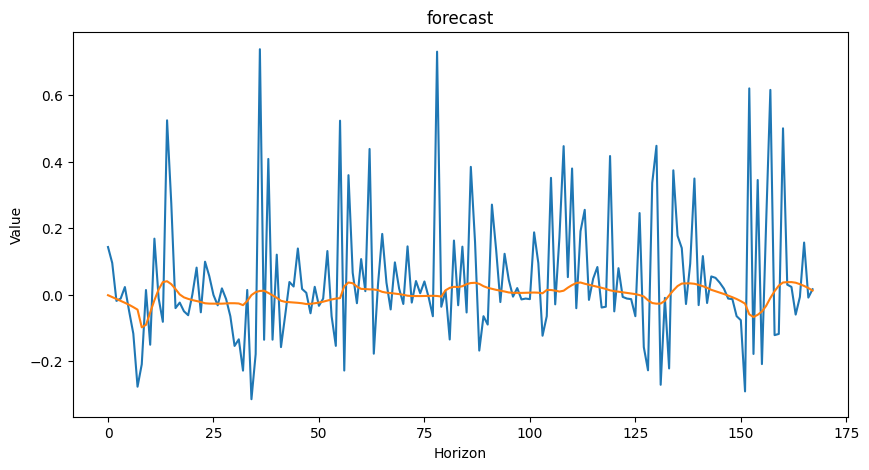

In [44]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = GRUForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)
model_name = "GRU"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')

Epoch 1/10, Train Loss: 0.0263, Val Loss: 0.0285
Epoch 2/10, Train Loss: 0.0248, Val Loss: 0.0297
Epoch 3/10, Train Loss: 0.0219, Val Loss: 0.0355
Epoch 4/10, Train Loss: 0.0176, Val Loss: 0.0380
Epoch 5/10, Train Loss: 0.0137, Val Loss: 0.0412
Epoch 6/10, Train Loss: 0.0112, Val Loss: 0.0436
Epoch 7/10, Train Loss: 0.0095, Val Loss: 0.0444
Epoch 8/10, Train Loss: 0.0086, Val Loss: 0.0456
Epoch 9/10, Train Loss: 0.0080, Val Loss: 0.0461
Epoch 10/10, Train Loss: 0.0077, Val Loss: 0.0469


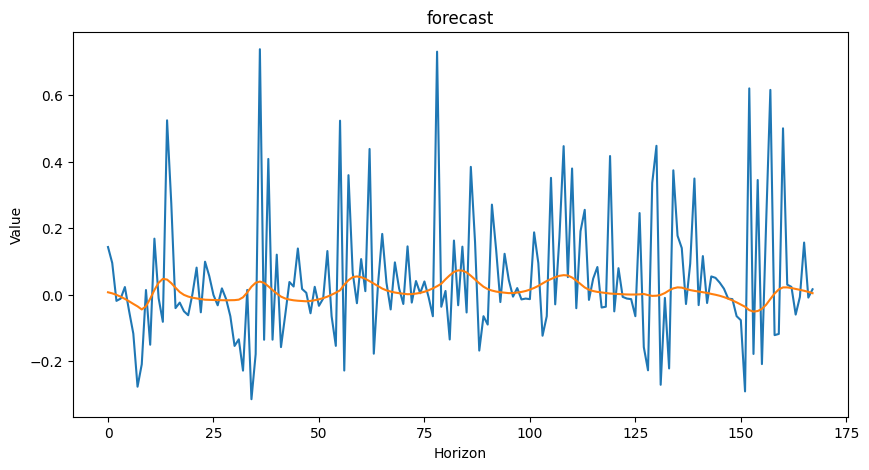

In [45]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , _ = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = LSTMForecast( #LSTMForecast
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "LSTM"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')


Epoch 1/10, Train Loss: 0.0264, Val Loss: 0.0284
Epoch 2/10, Train Loss: 0.0258, Val Loss: 0.0290
Epoch 3/10, Train Loss: 0.0252, Val Loss: 0.0305
Epoch 4/10, Train Loss: 0.0247, Val Loss: 0.0305
Epoch 5/10, Train Loss: 0.0243, Val Loss: 0.0300
Epoch 6/10, Train Loss: 0.0239, Val Loss: 0.0310
Epoch 7/10, Train Loss: 0.0236, Val Loss: 0.0315
Epoch 8/10, Train Loss: 0.0233, Val Loss: 0.0315
Epoch 9/10, Train Loss: 0.0232, Val Loss: 0.0322
Epoch 10/10, Train Loss: 0.0230, Val Loss: 0.0322


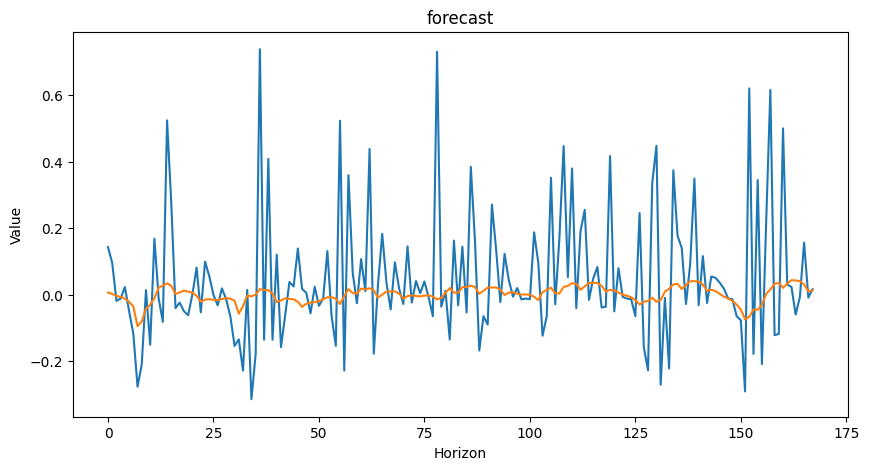

In [46]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0265, Val Loss: 0.0301
Epoch 2/10, Train Loss: 0.0259, Val Loss: 0.0292
Epoch 3/10, Train Loss: 0.0252, Val Loss: 0.0298
Epoch 4/10, Train Loss: 0.0247, Val Loss: 0.0298
Epoch 5/10, Train Loss: 0.0242, Val Loss: 0.0302
Epoch 6/10, Train Loss: 0.0238, Val Loss: 0.0307
Epoch 7/10, Train Loss: 0.0235, Val Loss: 0.0304
Epoch 8/10, Train Loss: 0.0232, Val Loss: 0.0308
Epoch 9/10, Train Loss: 0.0230, Val Loss: 0.0312
Epoch 10/10, Train Loss: 0.0229, Val Loss: 0.0308


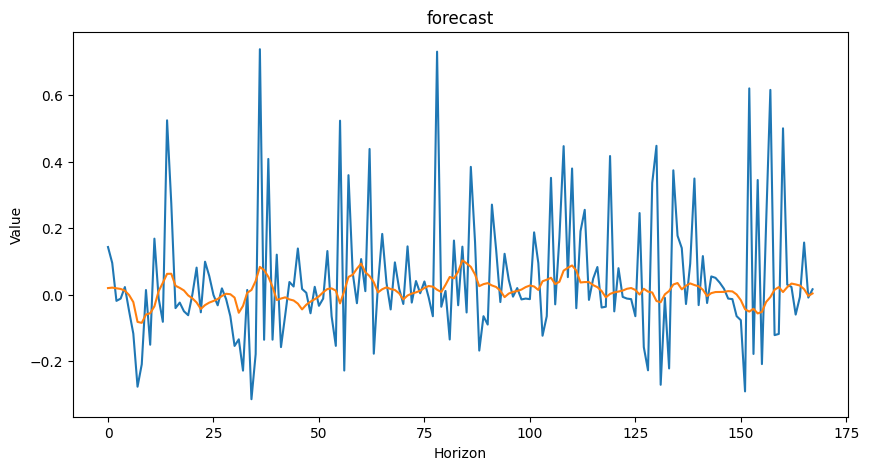

In [47]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = Seq2SeqForecast(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)


mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0266, Val Loss: 0.0286
Epoch 2/10, Train Loss: 0.0260, Val Loss: 0.0286
Epoch 3/10, Train Loss: 0.0254, Val Loss: 0.0298
Epoch 4/10, Train Loss: 0.0248, Val Loss: 0.0311
Epoch 5/10, Train Loss: 0.0241, Val Loss: 0.0298
Epoch 6/10, Train Loss: 0.0235, Val Loss: 0.0304
Epoch 7/10, Train Loss: 0.0230, Val Loss: 0.0308
Epoch 8/10, Train Loss: 0.0225, Val Loss: 0.0321
Epoch 9/10, Train Loss: 0.0222, Val Loss: 0.0325
Epoch 10/10, Train Loss: 0.0219, Val Loss: 0.0321


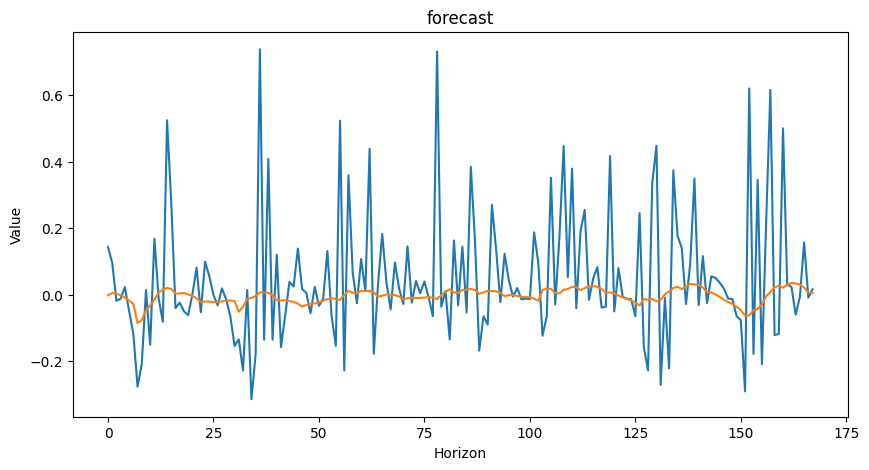

In [48]:


df = load_data(data, freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"

train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)


model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_attention"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



Epoch 1/10, Train Loss: 0.0265, Val Loss: 0.0303
Epoch 2/10, Train Loss: 0.0259, Val Loss: 0.0289
Epoch 3/10, Train Loss: 0.0251, Val Loss: 0.0296
Epoch 4/10, Train Loss: 0.0244, Val Loss: 0.0302
Epoch 5/10, Train Loss: 0.0236, Val Loss: 0.0310
Epoch 6/10, Train Loss: 0.0230, Val Loss: 0.0319
Epoch 7/10, Train Loss: 0.0224, Val Loss: 0.0332
Epoch 8/10, Train Loss: 0.0218, Val Loss: 0.0334
Epoch 9/10, Train Loss: 0.0215, Val Loss: 0.0339
Epoch 10/10, Train Loss: 0.0212, Val Loss: 0.0341


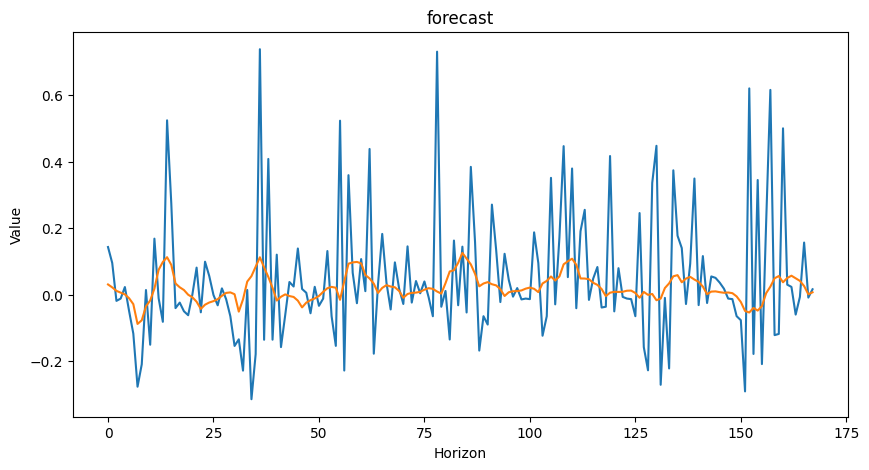

In [49]:


df = load_data(["outcoming.csv","incoming.csv"], freq=freq) # "outcoming.csv"  freq = "D" - по дням
df["sarima"] = model_fit.get_prediction(start=train.index[0], end=test.index[-1], dynamic=False).predicted_mean
df[f"{target}_diff"] = df[target]- df["sarima"]
target_ = f"{target}_diff"
train_loader, val_loader, input_size , features_size = prepare_data(
                                    df,
                                    target_,
                                    SEQ_LEN,
                                    TRAIN_HORIZON,
                                    EVAL_HORIZON,
                                    save_collumns=True,  # оставляем другие признаки (масса, строки)
                                    exoq = ["sarima"],
                                    batch_size=BATCH_SIZE)

model = AttentionSeq2Seq(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYER,
    time_feature_size=features_size
)

mae, rmse = train_model(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    learning_rate=LR
)

model_name = "SEQ2SEQ_attention_full"

mae_results[model_name] = mae.tolist()
rmse_results[model_name] = rmse.tolist()

torch.save(model.state_dict(), f'{save_dir}/{model_name}.pth')



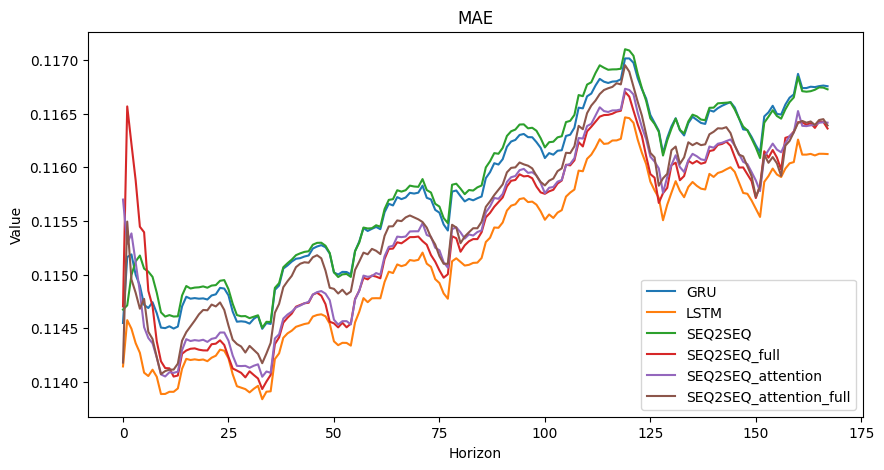

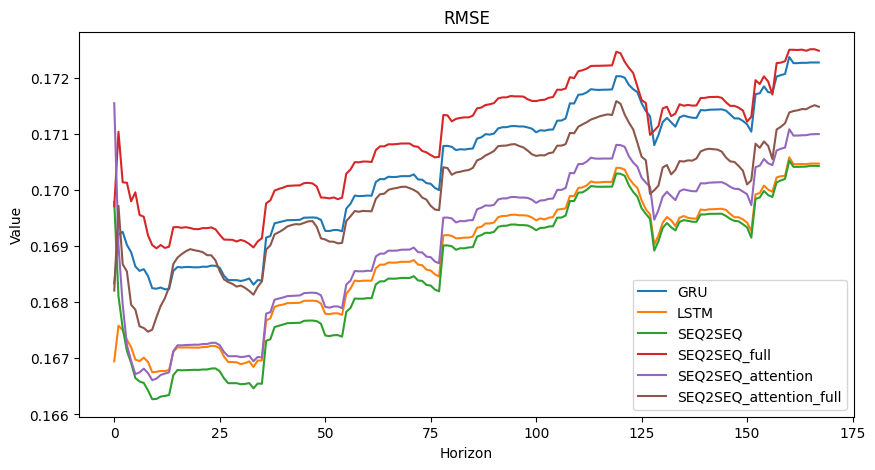

In [50]:
plot_metrics(mae_results, rmse_results)
save_results(save_dir, mae_results, rmse_results)